In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import gseapy as gp
import decoupler as dc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/tables"

/ocean/projects/cis240075p/asachan/.conda/envs/decoupler/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get the DEGs

In [2]:
########## file paths ##########

#fast2b
female_fast2b_path = os.path.join(working_dir, "Female_FastIIB_unfiltered_KO_DEGs.csv")
male_fast2b_path = os.path.join(working_dir, "Male_Fast IIB_unfiltered_KO_DEGs_nmt.csv")
#fast2x
female_fast2x_path = os.path.join(working_dir, "Female_FastIIX_unfiltered_KO_DEGs.csv")
male_fast2x_path = os.path.join(working_dir, "Male_Fast IIX_unfiltered_KO_DEGs_nmt.csv")
# #faps
# female_faps_path = os.path.join(working_dir, "Female_FAPs_unfiltered_KO_DEGs_nmt.csv")
# male_faps_path = os.path.join(working_dir, "Male_FAPs_unfiltered_KO_DEGs_nmt.csv")
# #musc
# female_musc_path = os.path.join(working_dir, "Female_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")
# male_musc_path = os.path.join(working_dir, "Male_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")


In [168]:
############ load cell-type specific DEGs ############

path_female_degs = female_fast2b_path
path_male_degs = male_fast2b_path
female_degs = pd.read_csv(path_female_degs, header=0)
female_degs.rename(columns={female_degs.columns[0]: 'gene_name'}, inplace=True)
male_degs = pd.read_csv(path_male_degs, header=0)
male_degs.rename(columns={male_degs.columns[0]: 'gene_name'}, inplace=True)

In [169]:
def create_ranked_genelist(deg_df, log2fc_col='avg_log2FC', pval_col='p_val_adj', gene_col='gene_name', min_pval=1e-300):
    """
    Create a ranked gene list based on signed log2FC * -log10(adjusted p-value)
    """
    df = deg_df.copy()
    # Clip p-values
    df[pval_col] = df[pval_col].clip(lower=min_pval)
    # Calculate components and final score
    df['neg_log10_pval'] = -np.log10(df[pval_col])
    df['ranking_score'] = df[log2fc_col] * df['neg_log10_pval']
    # Sort by absolute ranking score
    ranked_df = df.sort_values('ranking_score', ascending=False)
    # Create final DataFrame with gene names as columns
    ranked_list = ranked_df.set_index(gene_col)[['ranking_score']].T
    return ranked_list

In [170]:
gsea_female_degs = create_ranked_genelist(female_degs)
gsea_male_degs = create_ranked_genelist(male_degs)

In [171]:
print(gsea_female_degs['Atp2a1'])

ranking_score    43.792006
Name: Atp2a1, dtype: float64


## Load the genesets of interest (mouse)

In [7]:
# load msigDB all genesets for mice
msigdb_mice_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/msigdb.v2024.1.Mm.symbols.gmt"

In [8]:
from pathlib import Path

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """Parse a gmt file to a decoupler pathway dataframe."""
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [9]:
msigdb_mice = gmt_to_decoupler(msigdb_mice_gmt)
# Count unique genesets
n_unique_genesets = msigdb_mice['geneset'].nunique()
print(f"Number of unique genesets: {n_unique_genesets}")

Number of unique genesets: 16059


In [10]:
# Filtering genesets to match behaviour of fgsea
geneset_size = msigdb_mice.groupby("geneset").size()
# Index object of genesets that have more than 15 and less than 500 genes
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

### Select Pathways related to mitochondrial function

In [93]:
# Create a list of keywords you're interested in
keywords = [
    'OXIDATIVE_PHOSPHORYLATION',      # For oxidative phosphorylation
    'TCA',         # For TCA cycle
    'GLUTAMINE',   # For glutamine metabolism
    'CALCIUM',     # For calcium signaling
    'APOPTOSIS'    # For apoptosis
]

selected_pathways = [
    pathway for pathway in gsea_genesets
    if any(keyword.lower() in pathway.lower() for keyword in keywords)
]

display(len(selected_pathways))

86

In [84]:
# find the geneset that contains the gene 'Atp2a1'
serca_genesets = []
for geneset in selected_pathways:
    if 'Atp2a1' in msigdb_mice[msigdb_mice['geneset'] == geneset]['genesymbol'].values:
        serca_genesets.append(geneset)
        break

display(serca_genesets)

['GOBP_CALCIUM_ION_HOMEOSTASIS']

In [186]:
scores, norm, pvals = dc.run_gsea(
    gsea_male_degs,
    msigdb_mice[msigdb_mice["geneset"].isin(selected_pathways)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)
display(gsea_results.head())

,score,norm,pval
source,,,
GOBP_OXIDATIVE_PHOSPHORYLATION,0.918548,1.769351,0.000000
WP_APOPTOSIS,-0.937331,-1.609538,0.000000
HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.886939,1.750660,0.000000
WP_OXIDATIVE_PHOSPHORYLATION,0.912989,1.589818,0.013661
GOBP_NEGATIVE_REGULATION_OF_CALCIUM_ION_TRANSPORT,-0.922824,-1.509860,0.020934


In [187]:
# First prepare your data
# gsea_results = gsea_results[~gsea_results.index.str.startswith('WP')]
gsea_results['-log10(pval)'] = -np.log10(gsea_results['pval'].replace(0, 1e-300))
gsea_results['Group'] = gsea_results['score'].apply(lambda x: 'Up' if x > 0 else 'Down')
# Create a copy with reset index to get the pathway names as a column
plot_df = gsea_results.reset_index().copy()
plot_df[['Gene_set', 'Name']] = plot_df['source'].str.extract(r'(GOBP|REACTOME|KEGG|HALLMARK|GOMF|GOCC|GRAESSMANN|WP)_(.+)')
plot_df['Name'] = plot_df['Name'].apply(lambda x: '_'.join(x.split('_')[:6]))
plot_df = plot_df.loc[plot_df.groupby('Name')['-log10(pval)'].idxmax()]
# copy source column to a new column called 'Term'
plot_df['Term'] = plot_df['source']
plot_df['Term'] = plot_df['Term'].apply(lambda x: '_'.join(x.split('_')[:6]))
display(plot_df.head())


,source,score,norm,pval,-log10(pval),Group,Gene_set,Name,Term
1,WP_APOPTOSIS,-0.937331,-1.609538,0.000000,300.000000,Down,WP,APOPTOSIS,WP_APOPTOSIS
48,GRAESSMANN_APOPTOSIS_BY_SERUM_DEPRIVATION_DN,0.457677,0.807961,0.729977,0.136691,Up,GRAESSMANN,APOPTOSIS_BY_SERUM_DEPRIVATION_DN,GRAESSMANN_APOPTOSIS_BY_SERUM_DEPRIVATION_DN
6,GOMF_CALCIUM_CHANNEL_ACTIVITY,-0.882441,-1.493431,0.023697,1.625312,Down,GOMF,CALCIUM_CHANNEL_ACTIVITY,GOMF_CALCIUM_CHANNEL_ACTIVITY
51,GOCC_CALCIUM_CHANNEL_COMPLEX,-0.431513,-0.713143,0.848819,0.071185,Down,GOCC,CALCIUM_CHANNEL_COMPLEX,GOCC_CALCIUM_CHANNEL_COMPLEX
25,GOMF_CALCIUM_CHANNEL_REGULATOR_ACTIVITY,0.782114,1.233718,0.269461,0.569504,Up,GOMF,CALCIUM_CHANNEL_REGULATOR_ACTIVITY,GOMF_CALCIUM_CHANNEL_REGULATOR_ACTIVITY


## Plotting the enrichment results

In [18]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()

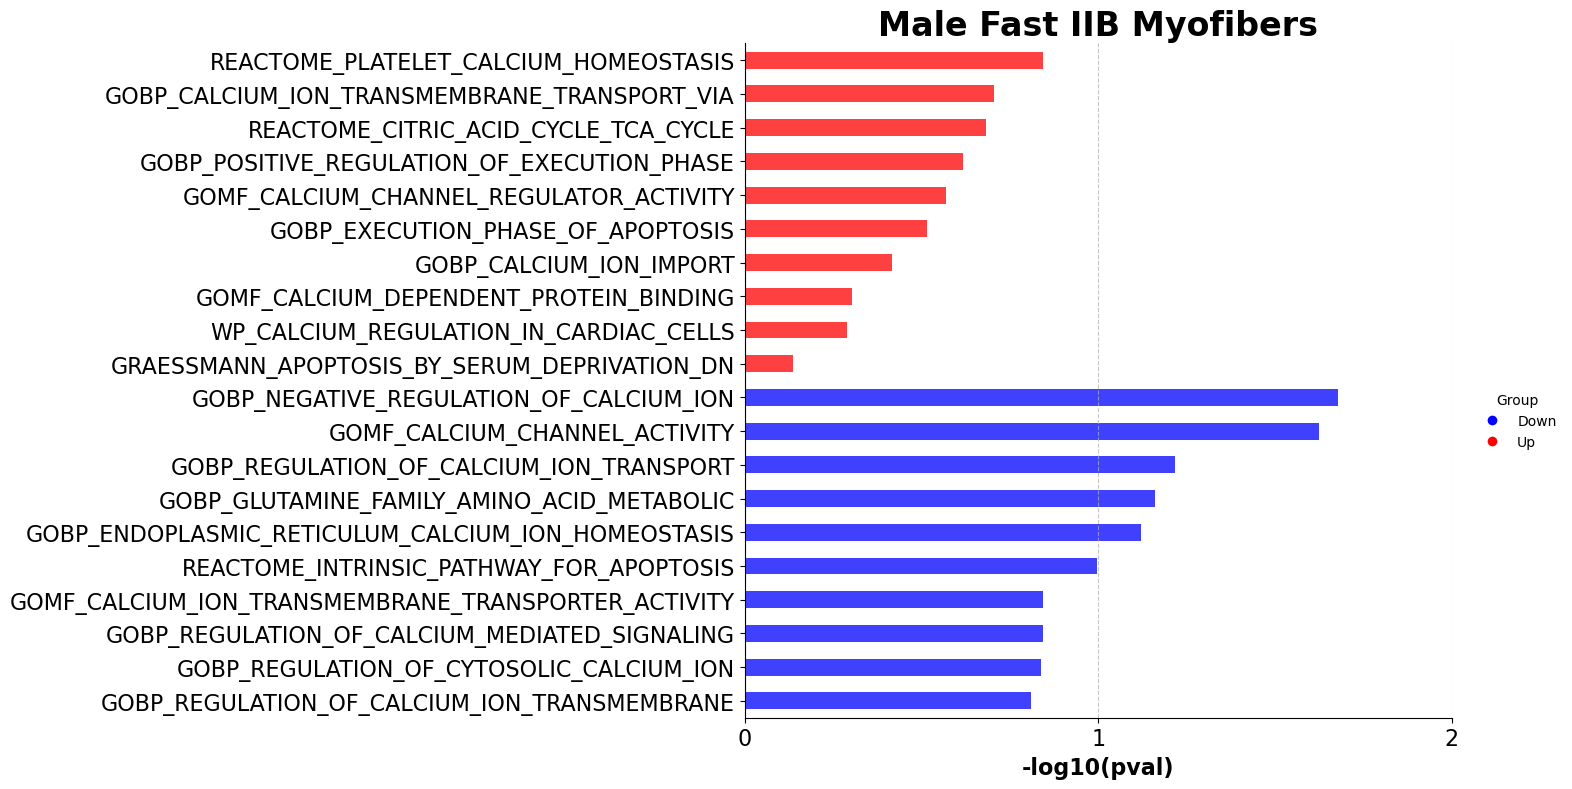

In [190]:
def simplify_term(term):
    # Convert to lowercase and split into words
    words = term.lower().replace('_', ' ').split()
    # Remove common words that don't add meaning
    stop_words = {'regulation', 'of', 'positive', 'negative', 'mediated', 'dependent', 
                 'activity', 'process', 'gobp', 'gomf', 'wp', 'reactome'}
    words = [w for w in words if w not in stop_words]
    return ' '.join(sorted(words))  # Sort words to match similar terms

# Create simplified terms and group by them
plot_df['simple_term'] = plot_df['Term'].apply(simplify_term)

# Keep only the most significant pathway for each simplified term
plot_df = plot_df.loc[plot_df.groupby('simple_term')['-log10(pval)'].idxmax()]

# Sort to put Up group at top
plot_df = plot_df.sort_values(['Group', '-log10(pval)'], ascending=[True, False])

ax = gp.barplot(
    df=plot_df,
    column='-log10(pval)',
    group='Group',
    title='Male Fast IIB Myofibers',
    color={'Up': 'red', 'Down': 'blue'},
    cutoff=2.0,
    figsize=(14, 8)
)

# Set x-axis limits and ticks
ax.set_xlim(0, 2)  # Fixed limit to 2.5
ax.set_xticks([0, 1, 2])  # Only show 0, 1, and 2
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.show()